<a href="https://colab.research.google.com/github/makhthum/MDS_Deakin_SIG742/blob/main/sit742task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


![Deakin University](https://www.freelogovectors.net/svg11/deakin-university-logo_freelogovectors.net.svg)

#Master of Data Science (MDS)
###SIG 742 – Modern Data Science | Trimester 2, 2025
####End Term Assesment 2025 - Group 1 - Team 6

---



Student Id   |     Student Name   
S225450659   |     Syed. Makhthum Peera    

# Part 1 - Data Acquisition and Manipulation

There are 8 questions in this part, totalling 60 marks. Each of question is worth 5 marks. Additionally, the quality of your explanation in both the report and video will collectively be worth 20 marks.   

You are recommended to use Google Colab to finish all the coding in the code block cell, and provide sufficient coding comments, and also save the result of running as well.   

The (business_review_submission.zip) data used for this part could be found in here. There are two files in the data. The first one is about the business review submission with many companies. For each of the row, the review submission is provided with relevant information such as user id, time, name and many others. The second one is the meta information of the business and the two data could be joined with gmap_id. You will need to use spark to first read the unzipped (csv) review data for starting and later join the meta review business data on dataframe (pandas or spark). You could find the code on reading csv data with Spark from M04G. In some of the tasks, if the question is not specifically asking to use spark, you could use both pandas and numpy.

https://github.com/tulip-lab/sit742/blob/develop/Jupyter/data/business_review_submission.zip

## Q1.1
Using PySpark to do some data wrangling process, so that:   
1.1.1 For the none or null in text column, change it to 'no review'.   
1.1.2 Process the content in time column, and convert the strings from time to yyyy-mm-dd format in the new column as newtime and show the first 5 rows.  

In [ ]:
import zipfile
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, when, from_unixtime, count
from pyspark.sql.types import FloatType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Ans 1.1

In [5]:
# Define the path to the zip file and the extraction directory
zip_file_path = '/content/business_review_submission.zip'
extract_dir = '/content/extracted_data'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Zip file extracted successfully.")
except zipfile.BadZipFile:
    print("Error: The downloaded file is not a valid zip file.")
    # You might want to add steps here to handle the error,
    # e.g., re-download the file or notify the user.


# List the extracted files to find the review submission csv file
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

# Assuming the review submission csv file is one of the extracted files, find it.
# You might need to adjust the filename based on the actual content of the zip.
review_csv_file = None
for file in extracted_files:
    if 'review.csv' in file:
        review_csv_file = os.path.join(extract_dir, file)
        break

if review_csv_file:
    print(f"Review submission file found: {review_csv_file}")

    # Initialize SparkSession
    spark = SparkSession.builder.appName("BusinessReviewAnalysis").getOrCreate()

    # Load the review data
    # review_df_spark = spark.read.csv(review_csv_file, header=True, inferSchema=True)
    try:
      review_df_spark = spark.read.csv(
        review_csv_file,
        header=True,          # Use first row as header
        inferSchema=True,     # Let Spark infer column types
        quote='"',            # Respect double quotes around text
        escape='"',           # Handle escaped quotes
        multiLine=True        # If text fields contain newlines
      )
      print("DataFrame successfully loaded.")
      review_df_spark.show(truncate=False)
      review_df_spark.printSchema()
    except Exception as e:
        print(f"Error loading DataFrame: {e}")
        # You might want to add steps here to handle the error
        # spark.stop() # Stop Spark if there was an error loading the DataFrame
        # exit() # Exit the script if DataFrame loading failed


    # 1.1.1 For the none or null in text column, change it to 'no review'.
    review_df_spark = review_df_spark.withColumn("text", when(col("text").isNull(), "no review").otherwise(col("text")))

    # 1.1.2 Process the content in time column, and convert the strings from time to yyyy-mm-dd format in the new column as newtime
    # Convert bigint 'time' to timestamp before formatting
    review_df_spark = review_df_spark.withColumn("newtime", date_format(from_unixtime(col("time")/1000), "yyyy-MM-dd"))


    # Show the first 5 rows with the newtime column
    review_df_spark.show(15)

    # Stop the SparkSession after all operations are done
    # spark.stop()


else:
    print("Review submission CSV file not found in the zip.")

Zip file extracted successfully.
Extracted files: ['review.csv', 'meta-review-business.csv']
Review submission file found: /content/extracted_data/review.csv
DataFrame successfully loaded.
+---------------------+-----------------+-------------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----

## Q1.2
Find out the information for gmap_id on the reviews. In order to achieve the above, some wrangling work is required to be done:   

1.2.1 Using pyspark to calculate the number of reviews per each unique gmap_id and save as float format in pyspark dataframe to show the top 5 rows.   

1.2.2 Transform the current pyspark dataframe to pandas dataframe (named as df) and create the column reivew_time with the information of review time on hours level. Print your df pandas dataframe with top 5 rows after creating the column review_time.   

1.2.3 Using matplotlib or seaborn to draw some (two or more if possible) visualizations on the relationship between gmap_id and reivew_time. You could explore for example, what is the time people usually review? How many business is reviewed in the morning time etc. Please also discuss the insights you are finding with your visualizations in the markdown cell. Please also include your findings and visualizations in the report.

### Ans 1.2

Review submission file found: /content/extracted_data/review.csv
DataFrame successfully loaded.
Number of reviews per unique gmap_id (PySpark DataFrame - top 5):
+--------------------+------------+
|             gmap_id|review_count|
+--------------------+------------+
|0x56c8977642a793f...|        27.0|
|0x56c79c63a5af15e...|        10.0|
|0x56c8976e16705e6...|        49.0|
|0x51325aac7a4434e...|        28.0|
|0x56c6631e3219094...|        12.0|
+--------------------+------------+
only showing top 5 rows


Pandas DataFrame with review_time_hour (top 5):


,user_id,name,time,rating,text,pics,resp,gmap_id,newtime,review_time_hour
0,1.091298e+20,Nicki Gore,1566331951619,5,We always stay here when in Valdez for silver ...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2019-08-20,0
1,1.132409e+20,Allen Ratliff,1504917982385,5,Great campground for the price. Nice hot unlim...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2017-09-09,0
2,1.130448e+20,Jonathan Tringali,1474765901185,4,We tent camped here for 2 nights while explori...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2016-09-25,0
3,1.103292e+20,S Blad,1472858535682,4,"This place is just a few miles outside Valdez,...",None,None,0x56b646ed2220b77f:0xd8975e316de80952,2016-09-02,0
4,1.089896e+20,Daniel Formoso,1529649811341,5,Probably the nicest and cleanest campground we...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2018-06-22,0


/tmp/ipython-input-3955353678.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='review_time_hour', palette='viridis')


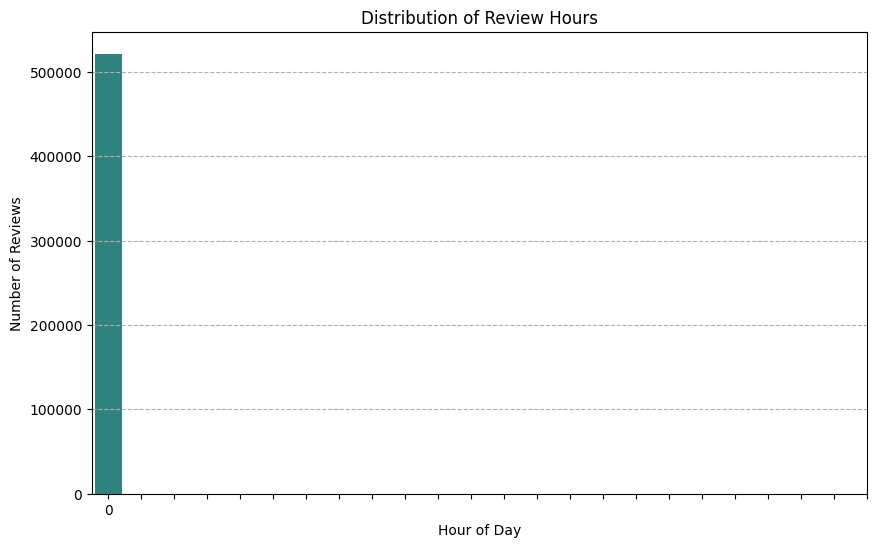

/tmp/ipython-input-3955353678.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=reviews_per_gmap_id_pandas_sorted.head(20), x='gmap_id', y='review_count', palette='magma')


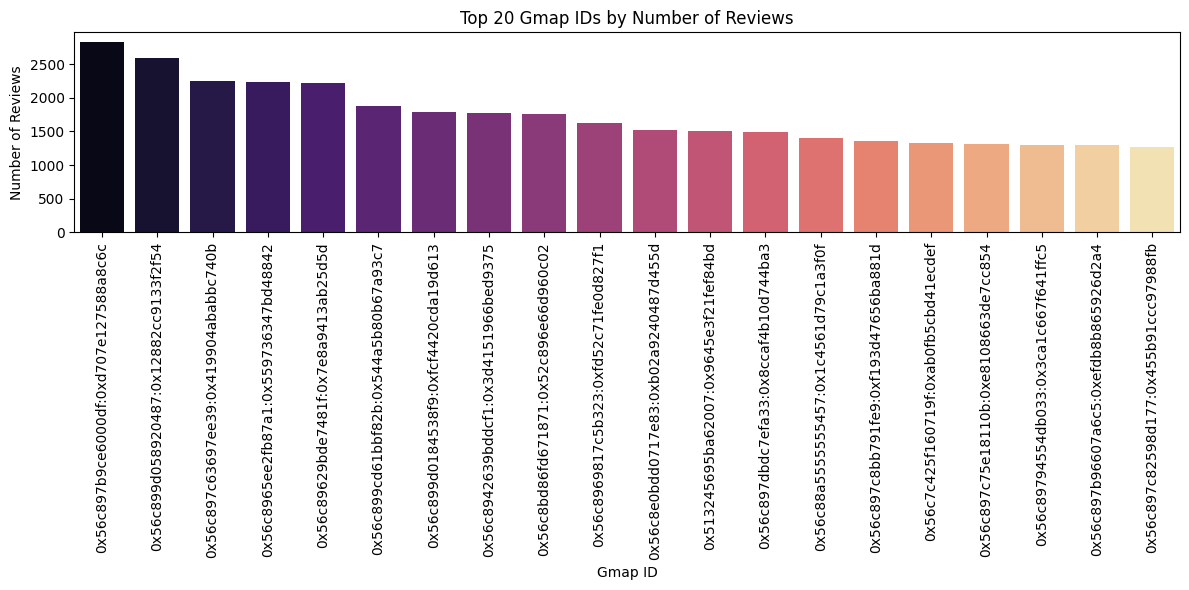

In [9]:
# 1.2.1 Using pyspark to calculate the number of reviews per each unique gmap_id and save as float format in pyspark dataframe to show the top 5 rows.

# Re-initialize SparkSession
spark = SparkSession.builder.appName("BusinessReviewAnalysis").getOrCreate()

# Define the extraction directory
extract_dir = '/content/extracted_data'

# Find the review submission csv file
review_csv_file = None
for file in os.listdir(extract_dir):
    if 'review.csv' in file:
        review_csv_file = os.path.join(extract_dir, file)
        break

if review_csv_file:
    print(f"Review submission file found: {review_csv_file}")

    # Load the review data
    try:
        review_df_spark = spark.read.csv(
            review_csv_file,
            header=True,          # Use first row as header
            inferSchema=True,     # Let Spark infer column types
            quote='"',            # Respect double quotes around text
            escape='"',           # Handle escaped quotes
            multiLine=True        # If text fields contain newlines
        )
        print("DataFrame successfully loaded.")

        # Apply transformations from Q1.1
        review_df_spark = review_df_spark.withColumn("text", when(col("text").isNull(), "no review").otherwise(col("text")))
        review_df_spark = review_df_spark.withColumn("newtime", date_format(from_unixtime(col("time")/1000), "yyyy-MM-dd"))

        # Calculate the number of reviews per gmap_id
        reviews_per_gmap_id_spark = review_df_spark.groupBy("gmap_id").agg(count("*").alias("review_count"))

        # Cast the review_count to FloatType
        reviews_per_gmap_id_spark = reviews_per_gmap_id_spark.withColumn("review_count", col("review_count").cast(FloatType()))

        # Show the top 5 rows
        print("Number of reviews per unique gmap_id (PySpark DataFrame - top 5):")
        reviews_per_gmap_id_spark.show(5)

        # 1.2.2 Transform the current pyspark dataframe to pandas dataframe (named as df)
        df = review_df_spark.toPandas()

        # create the column reivew_time with the information of review time on hours level.
        # Assuming 'newtime' is already in 'yyyy-MM-dd' format from Q1.1
        df['review_time_hour'] = pd.to_datetime(df['newtime']).dt.hour

        # Print your df pandas dataframe with top 5 rows after creating the column review_time.
        print("\nPandas DataFrame with review_time_hour (top 5):")
        display(df.head())

        # 1.2.3 Using matplotlib or seaborn to draw some (two or more if possible) visualizations

        # Example Visualization 1: Distribution of review hours
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x='review_time_hour', palette='viridis')
        plt.title('Distribution of Review Hours')
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Reviews')
        plt.xticks(range(24))
        plt.grid(axis='y', linestyle='--')
        plt.show()

        # Example Visualization 2: Number of reviews per gmap_id (using the calculated counts)
        # First, convert the reviews_per_gmap_id_spark to pandas for easier plotting
        reviews_per_gmap_id_pandas = reviews_per_gmap_id_spark.toPandas()
        reviews_per_gmap_id_pandas_sorted = reviews_per_gmap_id_pandas.sort_values(by='review_count', ascending=False)

        plt.figure(figsize=(12, 6))
        # Displaying top 20 gmap_ids for better visualization
        sns.barplot(data=reviews_per_gmap_id_pandas_sorted.head(20), x='gmap_id', y='review_count', palette='magma')
        plt.title('Top 20 Gmap IDs by Number of Reviews')
        plt.xlabel('Gmap ID')
        plt.ylabel('Number of Reviews')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        # You can add more visualizations here to explore the relationship between gmap_id and review_time_hour
        # For example, you could look at the average review hour per gmap_id or the distribution of hours for a specific gmap_id

    except Exception as e:
        print(f"Error processing DataFrame: {e}")

    finally:
        # Stop the SparkSession after all operations are done
        spark.stop()

else:
    print("Review submission CSV file not found in the zip.")

## Q1.3

Let’s continue to analyze the reivew_time with reviews and related gmap_id. You need to use another data meta-business to join with the current dataframe on gmap_id.   

1.3.1 Determine which workday (day of the week), generates the most reviews (plotting the results in a line chart with workday on averaged submissions).

1.3.2 Identify the names of business (column name from data meta-business) that has the highest averaged ratings on ‘that workday’ (you need to find out from 1.3.1), and find out which category those businesses are from?

1.3.3 Please further explore the data on name of business and find out some more insights by yourself such as which category it is and what are the peak hours etc. Please use visualizations and tables to support your findings and write down the insights in the markdown cell. Please also include your findings and visualizations in the report.

### Ans 1.3

## Q1.4

For the reviews on each of the submissions, work on all the review content and find out the top 30 most common words; Also generate separate word cloud visualizations for different years by grouping the reviews by review year and write down the insights in the markdown cell. Please also include your findings and visualizations in the report.

###Ans 1.4

##Q1.5
Let’s do some analysis on the business_name and the reviewers. Determine the number of unique reviewers of business and its categories to identify which business / category has attracted the most reviewers (find out the highest distinct count of reviewers on business / category level). Also, analyze the temporal patterns of when reviewers submitted their reviews (you could leverage the workday, year, month, or hours to conduct the analysis) and share your findings and insights in the markdown cell. Please also include your findings and insights (visualizations) in the report.

### Ans 1.5

##Q1.6
As the data scientist, you are required to build a recommendation for the business by using reviews, ratings, and its categories. In this task, you need to:

1.6.1 Write down your strategy of building the recommendation on business for customers in the markdown cell. You could create your own strategy or leverage the provided one here KNN on collaborative filtering. Please also include your strategy details in the report.

1.6.2 Could you please try to implement the strategy (code) you have written down for the recommendation system? Please give detailed explanation of your code and the logic in the comments and also interpret the recommendations with examples in the markdown cell. Please also include your implementation details and results in the report.

### Ans 1.6

##Q1.7

Continue work on the review data you have now, for each of the submissions of the review, you will need to explore the rating with other information:

1.7.1 Build visualization to explore the relationships of the rating and business categories. Please write down your insights in the markdown cell and also include your insights and visualizations in the report.

1.7.2 Let’s focus on the lower ratings now. Could you please find out the actual reviews on lower ratings and analyze on the reason? (You could use the common used words in lower rating reviews or design your own strategy with reasonable logic). Please also include your analysis details in the report.

###Ans 1.7

##Q1.8

Continue to work on the submission of the reviews, we would like to focus on the reviewer level with all the reviewed business history, but before we actually conduct the programming, we will need to finish few questions for exploration:

1.8.1 Check on the reviewer level reviewed business, sort the review of each business by the review time (newtime column) and then save the business name into the list variable user_business_list for each reviewer.

1.8.2 Check on the user_business_list, could you observe some repeated business names for the same user? If so, could you remove those duplicated business names under same user? Please print out the number of element in the user_business_list for each reviewer before removing the duplicated business name and after removing the duplicated business name.

1.8.3 Check on the user_business_list, could you find the user similarities according to their past reviewed business ? You are free to design your own strategy and give sufficient explanation in markdown cell and code implementation together. Please also include your strategy details and implementation in the report.

Hint: you might consider to use encoding for each of the business names and then calculate the difference of the users.

###Ans 1.8

# Part 2 - Submission Prediction

There are 3 questions in this part, totaling 40 marks. Each question is worth 10 marks. Additionally, the quality of your explanation in both the report and video will collectively be worth 10 marks.  
You are required to use Google Colab to finish all the coding in the code block cell, and provide sufficient coding comments, and also save the result of running as well.

##Q2.1

In this question, we will focus only on two information: total reviews per day with review time (newtime from the dataframe) to form the review volume time series. You are required to explore the review time series. There are some days not available in the review time series. Please add those days into the review time series with default number of review with the mean value of the number of review per day in the whole data (without any filtering on reviews). After that, decompose the submission review time series with addictive mode and analyses on the results to find if there is any seasonality pattern (you could leverage the M05A material from lab session with default setting in seasonal_decompose function). Please also include your analysis details and implementation in the report.

###Ans 2.1

##Q2.2

We will try to use time series model ARIMA for forecasting the future. You need to find the best model with different parameters on ARIMA model. The parameter range for p,d,q are all from [0, 1, 2]. In total, you need to find out the best model with lowest Mean Absolute Error from 27 choices (you might need to split the time series to train and test with yourself with grid search according to the M05B material). Also, you are required to discuss with your group member on exploring the deep learning time series forecasting methods such as LSTM and RNN. Please write down your discussion around the necessary data wrangling and modeling steps (steps on how to achieve, not actual code). Also please give the reference of the deep learning time series forecasting models you are using. Please also include your discussion details and implementation in the report.

###Ans 2.2

##Q2.3

In this question, you are provided with the PDF file by Universities Australia via Indigenous Strategy annual report. You are required to critically analyze this report using your data science skills.

**Data Extraction** Carefully review the PDF and identify all relevant quantitative data, tables, and figures that can be extracted or digitized; Present any extracted data in a structured format (e.g., CSV, Excel table, or DataFrame);

**Data Analysis** Utilize your data analytics skills to discover common patterns or trends from the report; Where possible, compare trends over multiple years, between institutions, or across different Indigenous strategy metrics.

**Insights** Provide a clear and concise summary of the main patterns, trends, or correlations discovered from your analysis; Interpret what these findings reveal about the progress and challenges of Indigenous strategies in Australian universities.

You may use any data analytics tools or libraries you are comfortable with. All steps, from extraction to insights, should be clearly documented in your SIT742Task2Report.pdf, and source code should be in SIT742Task2Code.ipynb.

https://universitiesaustralia.edu.au/wp-content/uploads/2022/08/UA_Indigenous_Strategy_Annual_Report_May-2022.pdf

###Ans 2.3